Saved analogue indices → analog_idx.npy ((577, 10))
Saved analogue distances → analog_dist.npy ((577, 10))
Saved flags CSV → macro_zscores_with_flags.csv ((577, 10))


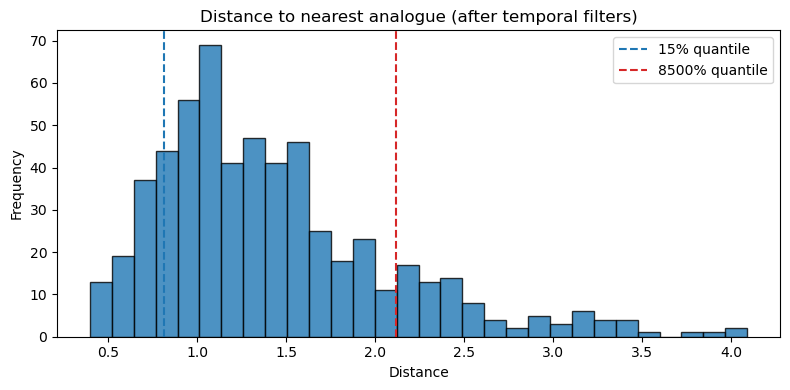

In [1]:
#!/usr/bin/env python3
"""
build_analogues.py

Compute K-nearest-neighbour analogue indices and distances from macro Z-scores,
apply temporal exclusion and past-only constraints, flag most-similar and anti-similar
months, and save outputs for back-testing.
"""

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

# ── Paths ──────────────────────────────────────────────────────────────────────
DATA_DIR    = Path("../data/processed")
Z_FILE      = DATA_DIR / "macro_zscores_monthly.csv"
IDX_FILE    = DATA_DIR / "analog_idx.npy"
DST_FILE    = DATA_DIR / "analog_dist.npy"
FLAGS_FILE  = DATA_DIR / "macro_zscores_with_flags.csv"

# ── Hyper-parameters ───────────────────────────────────────────────────────────
K_NEIGHB   = 10           # number of analogues to keep (excluding self)
METRIC     = "euclidean"  # distance metric for pairwise_distances
TOP_PCT    = 0.15         # quantile for sim/anti flags
EXCL_RADIUS = 1           # exclude neighbours within ± this many months
PAST_ONLY   = True        # only allow analogues from the past

# ── Load Z-scores ──────────────────────────────────────────────────────────────
z = pd.read_csv(Z_FILE, index_col=0, parse_dates=True)
dates = z.index.to_numpy()
Z = z.values  # shape (n_months, n_features)
n = Z.shape[0]

# ── Compute full pairwise distance matrix ─────────────────────────────────────
dist_matrix = pairwise_distances(Z, metric=METRIC)

# ── Allocate output arrays ─────────────────────────────────────────────────────
analog_idx  = np.full((n, K_NEIGHB), fill_value=-1, dtype=int)
analog_dist = np.full((n, K_NEIGHB), fill_value=np.nan, dtype=float)

# ── Build neighbour lists with temporal filters ────────────────────────────────
for i in range(n):
    # distances from month i to all months
    dists = dist_matrix[i]
    # candidate indices excluding self
    candidates = [j for j in range(n) if j != i]
    # apply EXCL_RADIUS filter
    candidates = [j for j in candidates
                  if abs(j - i) > EXCL_RADIUS]
    # apply PAST_ONLY filter
    if PAST_ONLY:
        candidates = [j for j in candidates if j < i]
    # sort candidates by distance
    candidates.sort(key=lambda j: dists[j])
    # take top K_NEIGHB
    sel = candidates[:K_NEIGHB]
    # record
    analog_idx[i, :len(sel)]  = sel
    analog_dist[i, :len(sel)] = dists[sel]

# ── Save arrays ───────────────────────────────────────────────────────────────
np.save(IDX_FILE, analog_idx)
np.save(DST_FILE, analog_dist)
print(f"Saved analogue indices → {IDX_FILE.name} ({analog_idx.shape})")
print(f"Saved analogue distances → {DST_FILE.name} ({analog_dist.shape})")

# ── Flag most-similar / anti-similar months ────────────────────────────────────
nearest_d = analog_dist[:, 0]
finite_d  = nearest_d[np.isfinite(nearest_d)]
low_q     = np.quantile(finite_d, TOP_PCT)
high_q    = np.quantile(finite_d, 1 - TOP_PCT)

z_flags = z.copy()
z_flags["sim_flag"]  = (nearest_d <= low_q).astype(int)
z_flags["anti_flag"] = (nearest_d >= high_q).astype(int)

z_flags.to_csv(FLAGS_FILE)
print(f"Saved flags CSV → {FLAGS_FILE.name} ({z_flags.shape})")

# ── Plot histogram of nearest distances ────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.hist(finite_d, bins=30, alpha=0.8, edgecolor='black')
plt.axvline(low_q,  ls="--", color="tab:blue", label=f"{TOP_PCT:.0%} quantile")
plt.axvline(high_q, ls="--", color="tab:red",  label=f"{100-100*TOP_PCT:.0%} quantile")
plt.title("Distance to nearest analogue (after temporal filters)")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
